In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WQIX3N0AouohId9nmwju")
project = rf.workspace("work-gorze").project("licence_plate_segmentation_india")
dataset = project.version(1).download("png-mask-semantic")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.76
    Uninstalling opencv-python-headless-4.8.0.76:
      Successfully uninstalled 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to licence_plate_segmentation_india-1 in png-mask-semantic:: 100%|██████████| 3526/3526 [00:00<00:00, 4185.68it/s]


In [3]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers import Conv2D, Input, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info
from keras.layers import add

NETWORK_W = 416
NETWORK_H = 416

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'


from keras.layers import Conv2D, BatchNormalization, LeakyReLU, add

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    skip_connection = None

    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1

        if conv['stride'] > 1:
            x = ZeroPadding2D(((1, 0), (1, 0)), name='zerop_' + str(conv['layer_idx']))(x)

        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)

        if conv['bnorm']:
            x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)

        if conv['activ'] == 1:
            x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2:
            x = Activation('relu', name='relu_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x], name='add_' + str(conv['layer_idx'] + 1)) if skip else x

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.applications import EfficientNetB1

def multi_unet_model3(n_classes=2, IMG_H=416, IMG_W=416, IMG_CHANNELS=3):

    input_image = Input(shape=(416,416, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
    layer_0 = x
    # Layer  1
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x

    # Layer  2
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x

    # route  1 (layers = -2)
    x = layer_1
    # Layer  3 => 5
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                   skip = True)

    # Layer  8 => 8
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x

    # route  8+2 (layers = -1, -7)
    x = concatenate([layer_8, layer_2], name='concat_9')

    # Layer 10 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x

    # Layer  12
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x

    # route  11 (layers = -2)
    x = layer_11
    # Layer 14 => 16
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                   skip = True)

    # Layer 18 => 19
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                   skip = True)

    # Layer  21
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}])
    layer_21 = x

    # route  21+12 (layers = -1,-10)
    x = concatenate([layer_21, layer_12], name='concat_22')

    # Layer 23 => 24
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x

    # Layer  25
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x



    # route  52+25 (layers = -1,-28)
    x = layer_25

    print(x.shape)
    # Upsample to (152, 150, 128)
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    print(x.shape)
    # Upsample to (304, 300, 64)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    print(x.shape)
    # Further upsample to (512, 512, 32)
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    print(x.shape)
    # Convolutional layer to adjust the number of channels to 3
    output_tensor = Conv2D(3, (1, 1), activation='relu')(x)
    print(output_tensor.shape)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(output_tensor)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)



    model = Model(inputs=[input_image], outputs=[outputs])

    # Compile the model
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [5]:
!mkdir mask

In [6]:
import os
import shutil

# Replace these paths with your actual source and destination folder paths
source_folder = '/content/licence_plate_segmentation_india-1/train/'
destination_folder = '/content/mask'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate through the files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith('_mask.png'):  # Assuming mask images end with '_mask.png'
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.move(source_path, destination_path)
        print(f"Moved {filename} to {destination_folder}")


Moved f7ba7a93-e8d7-4253-b327-d87e3f2bb747___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_2013-Nissan-Terrano-Rear_jpg.rf.3e06ee00154f8945b4abcc5558f1eac0_mask.png to /content/mask
Moved video4_2310_jpg.rf.7f78bf947b22db7ed66c187e27e29698_mask.png to /content/mask
Moved HP21_jpg.rf.03eff68f373ba60b9709e562fcd23554_mask.png to /content/mask
Moved video4_2310_jpg.rf.cccdb7672ae47b4030b992525e00c35c_mask.png to /content/mask
Moved fac9f4e6-c4b9-4872-86da-79d58ea2adc5___5273-jpg_jpeg.rf.253ed4058effc611452b42bd23f84794_mask.png to /content/mask
Moved video3_1850_jpg.rf.964447737329905237ec500a3e931c77_mask.png to /content/mask
Moved video3_1820_jpg.rf.959012cb885749a6a4d6db8ba59a64bb_mask.png to /content/mask
Moved video3_450_jpg.rf.abb3cc1ff1d73efec1a72221e198189b_mask.png to /content/mask
Moved video6_1130_jpg.rf.820d4892441d42d70a4814524d9e8225_mask.png to /content/mask
Moved 20210502_05_59_35_000_ovRKxW0QbBVfwN9RW4teROP1YgG3_F_4160_3120_jpg.rf.455d29c557219c8c4604b6587a484358_mask.png to /cont

In [7]:



from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


#Resizing images, if needed
SIZE_X = 416
SIZE_Y = 416
n_classes=2 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/licence_plate_segmentation_india-1/train/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)


#Convert list to array for machine learning processing
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/mask"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_masks = np.array(train_masks)



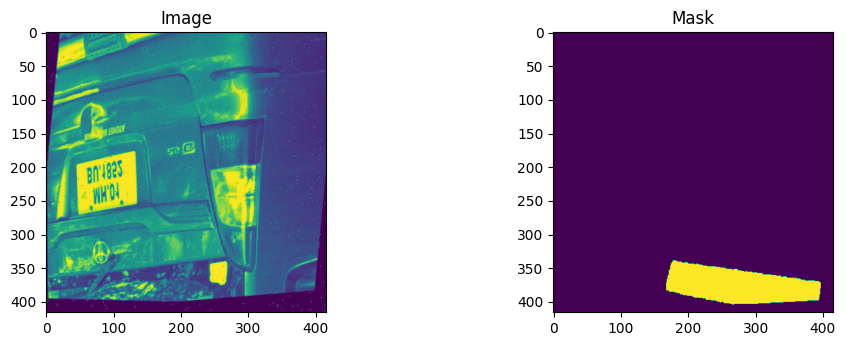

In [8]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[img_number]
mask = train_masks[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()




In [9]:
train_masks.shape
train_images.shape

(1761, 416, 416)

# this is not windows

In [10]:
import glob
import cv2
image_names = glob.glob("/content/licence_plate_segmentation_india-1/train/*.jpg")
image_names.sort()
image_names = image_names[0:500]


In [11]:
print(image_names)

['/content/licence_plate_segmentation_india-1/train/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.11afa47f3436878ec0b94dae645fd478.jpg', '/content/licence_plate_segmentation_india-1/train/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.14b7bec636d5c9057b2c1000405b5d9d.jpg', '/content/licence_plate_segmentation_india-1/train/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.38ff3d55fe0ff458f77f962af5c7fd43.jpg', '/content/licence_plate_segmentation_india-1/train/00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle_jpg.rf.33f2e9dcb226b5457fd800eb1718dd7a.jpg', '/content/licence_plate_segmentation_india-1/train/00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle_jpg.rf.9b50668d5b266cd39900e58e288265e9.jpg', '/content/licence_plate_segmentation_india-1/train

In [ ]:

#images = [cv2.imread(image, 1) for image in image_names]
#image_dataset = np.array(images)

In [12]:
# Initialize an empty list to store resized images
resized_images = []

# Define the target size (416x416 pixels)
target_size = (416, 416)

# Loop through the list of image file paths
for image_path in image_names:
    # Read the image using OpenCV
    image = cv2.imread(image_path, 1)  # 1 for loading color image

    # Check if the image was successfully loaded
    if image is not None:
        # Resize the image to the target size
        resized_image = cv2.resize(image, target_size)

        # Append the resized image to the list
        resized_images.append(resized_image)

# Convert the list of resized images to a NumPy array
image_dataset = np.array(resized_images)


In [13]:

mask_names = glob.glob("/content/mask/*.png")
mask_names.sort()
mask_names = mask_names[0:500]

In [14]:
print(mask_names)

['/content/mask/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.11afa47f3436878ec0b94dae645fd478_mask.png', '/content/mask/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.14b7bec636d5c9057b2c1000405b5d9d_mask.png', '/content/mask/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.38ff3d55fe0ff458f77f962af5c7fd43_mask.png', '/content/mask/00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle_jpg.rf.33f2e9dcb226b5457fd800eb1718dd7a_mask.png', '/content/mask/00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle_jpg.rf.9b50668d5b266cd39900e58e288265e9_mask.png', '/content/mask/00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle_jpg.rf.d80c83efdcfd2dc637769a5af7ad9724_mask.png', '/content

In [ ]:

#masks = [cv2.imread(mask,0) for mask in mask_names]
#mask_dataset = np.array(masks)

In [15]:
# Initialize an empty list to store resized mask images
resized_masks = []

# Define the target size (e.g., 416x416 pixels)
target_size = (416, 416)

# Loop through the list of mask image file paths
for mask_path in mask_names:
    # Read the mask image using OpenCV
    mask_image = cv2.imread(mask_path, 0)  # 0 for loading grayscale image

    # Check if the mask image was successfully loaded
    if mask_image is not None:
        # Resize the mask image to the target size
        resized_mask = cv2.resize(mask_image, target_size)

        # Append the resized mask image to the list
        resized_masks.append(resized_mask)

# Convert the list of resized mask images to a NumPy array
mask_dataset = np.array(resized_masks)

In [16]:
image_dataset.shape
mask_dataset.shape

(500, 416, 416)

In [17]:
import numpy as np
np.unique(mask_dataset)


array([0, 1], dtype=uint8)

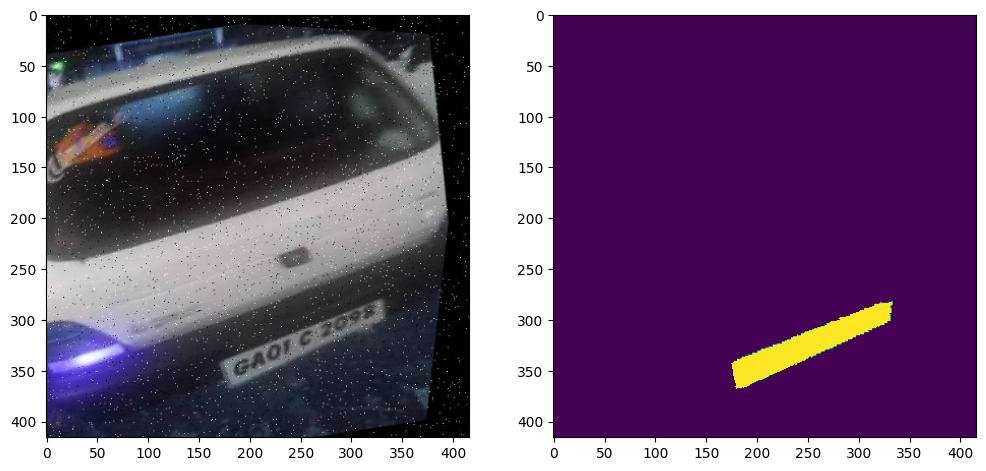

In [18]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

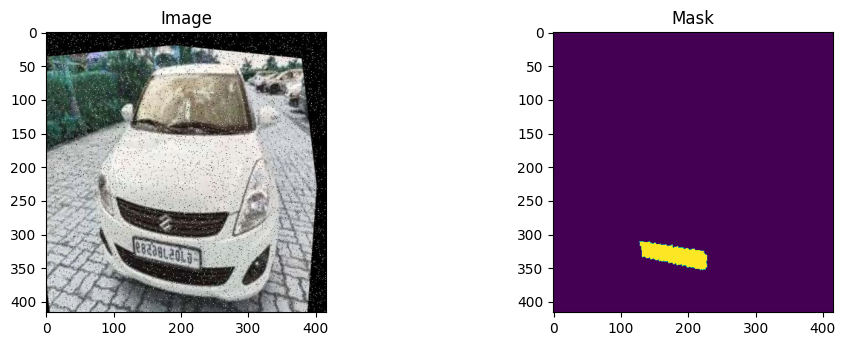

In [19]:

import random
img_number = random.randint(0, len(image_dataset)-1)
img = image_dataset[img_number]
mask = mask_dataset[img_number]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()


In [20]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
train_masks_reshaped = mask_dataset.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([0, 1])

In [21]:
#############################################

#################################################
train_images = np.expand_dims(image_dataset, axis=3)
train_images = normalize(image_dataset, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, train_masks_input, test_size = 0.10, random_state = 0)


print("Class values in the dataset are ... ", np.unique(y_train.ravel()))


print(n)
print(h)
print(w)

Class values in the dataset are ...  [0 1]
500
416
416


In [22]:
from keras.utils import to_categorical

# Convert class labels to categorical representation
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [24]:


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)




def get_model():
    return multi_unet_model3(n_classes=n_classes, IMG_H=IMG_HEIGHT, IMG_W=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights.
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat,
                    batch_size = 8,
                    verbose=1,
                    epochs=25,
                    validation_data=(X_test, y_test_cat),
                    #class_weight=class_weights,
                    shuffle=False)


416
416
3
(None, 52, 52, 128)
(None, 104, 104, 128)
(None, 208, 208, 64)
(None, 416, 416, 32)
(None, 416, 416, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 convn_0 (Conv2D)            (None, 416, 416, 32)         896       ['input_0[0][0]']             
                                                                                                  
 BN_0 (BatchNormalization)   (None, 416, 416, 32)         128       ['convn_0[0][0]']             
                                                                                                  
 relu_0 (Activation)         (None, 416, 416, 32)         0         ['BN_0[0]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


2/2 [==============================] - 19s 7s/step - loss: 0.0244 - accuracy: 0.9941
Accuracy is =  99.4070827960968 %


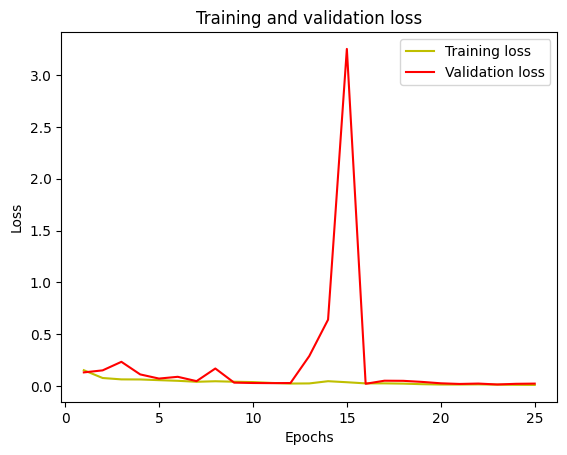

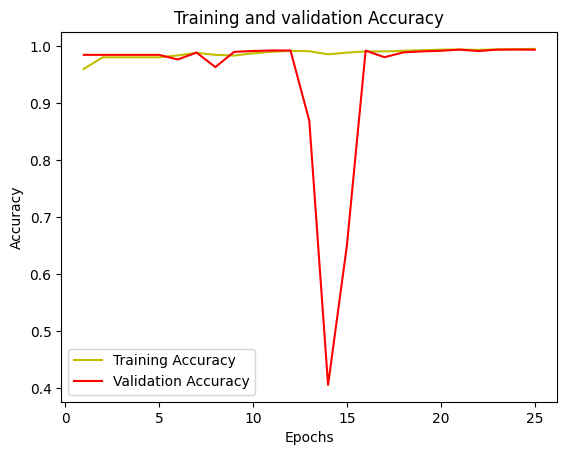

In [25]:
model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Replace 'acc' with 'accuracy' for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




2/2 [==============================] - 1s 274ms/step - loss: 0.0244 - accuracy: 0.9941
Accuracy is =  99.4070827960968 %


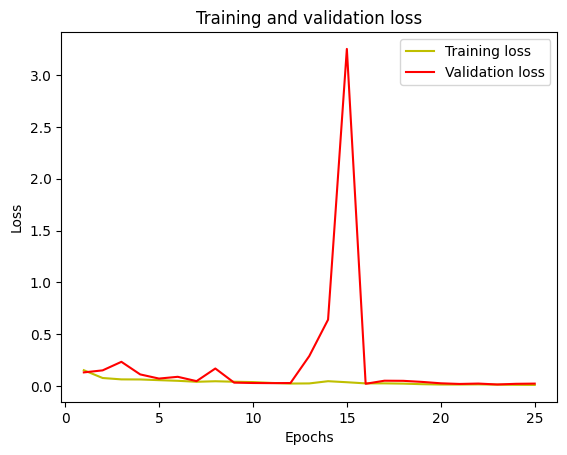

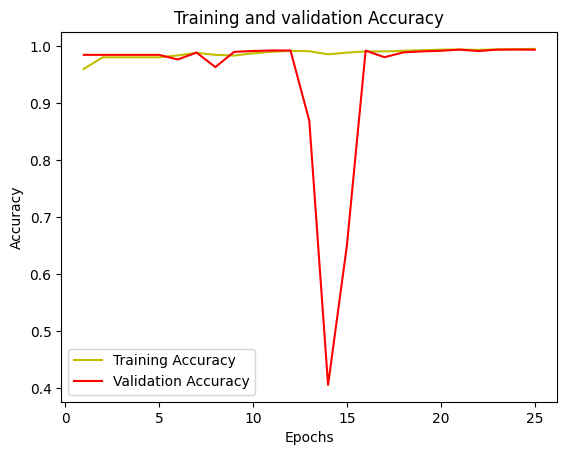

In [26]:
from keras.models import load_model
import tensorflow as tf
# Save the model in the SavedModel format
tf.saved_model.save(model, 'saved_model')

# Load the saved model
loaded_model = tf.saved_model.load('saved_model')


#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Replace 'acc' with 'accuracy' for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


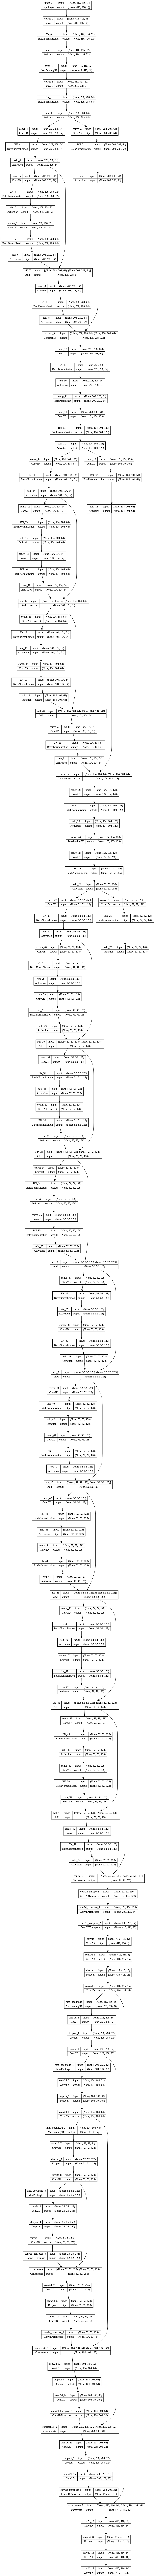

In [26]:
!pip install pydot
!sudo apt-get install graphviz
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load the model
model = load_model('/content/test.hdf5')  # Load your model here

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)

2/2 [==============================] - 1s 470ms/step
Mean IoU = 0.80996144
IoU for class1 is:  0.9940114
IoU for class2 is:  0.6259115


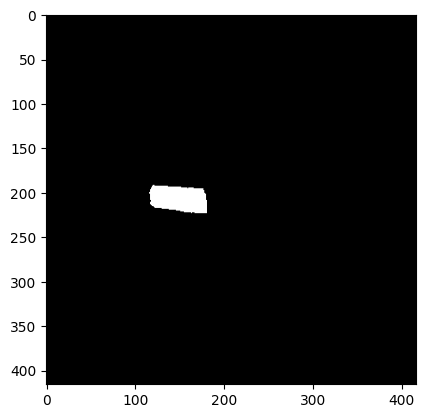

In [27]:
##################################
#model = get_model()
model.load_weights('/content/test.hdf5')
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')





#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


# Calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

class1_IoU = values[0, 0] / (np.sum(values[0, :]) + np.sum(values[:, 0]) - values[0, 0])
class2_IoU = values[1, 1] / (np.sum(values[1, :]) + np.sum(values[:, 1]) - values[1, 1])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)


plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
#######################################################################



You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


2/2 [==============================] - 1s 274ms/step - loss: 0.0244 - accuracy: 0.9941
Accuracy is =  99.4070827960968 %


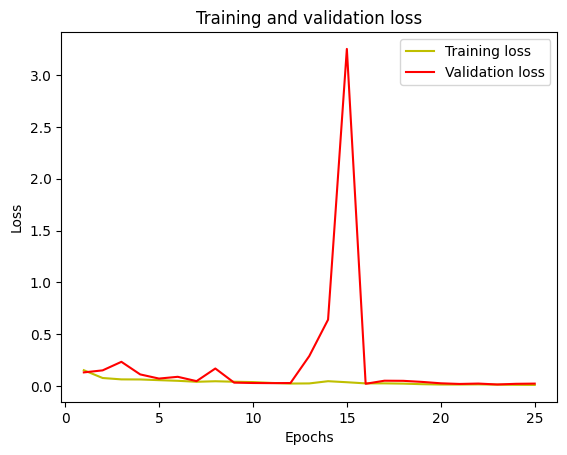

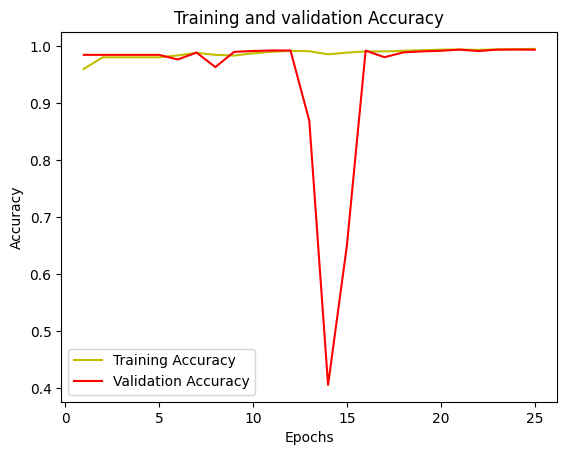

In [28]:
model.save('test1.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Replace 'acc' with 'accuracy' for training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



1/1 [==============================] - 1s 1s/step


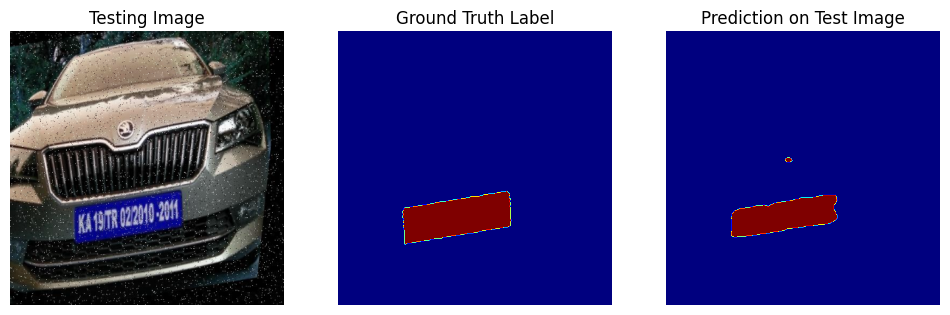

In [29]:
import random
import matplotlib.pyplot as plt

# Randomly select a test image
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

# Expand the dimensions to (1, x, y, 3) to represent a single color image
test_img = np.expand_dims(test_img, axis=0)

# Predict using the model
y_pred = model.predict(test_img)
y_pred_argmax = np.argmax(y_pred, axis=3)[0]

# Display the images
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[0], cmap='gray')  # Display the color image
plt.axis('off')

plt.subplot(232)
plt.title('Ground Truth Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet')
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(y_pred_argmax, cmap='jet')
plt.axis('off')

plt.show()


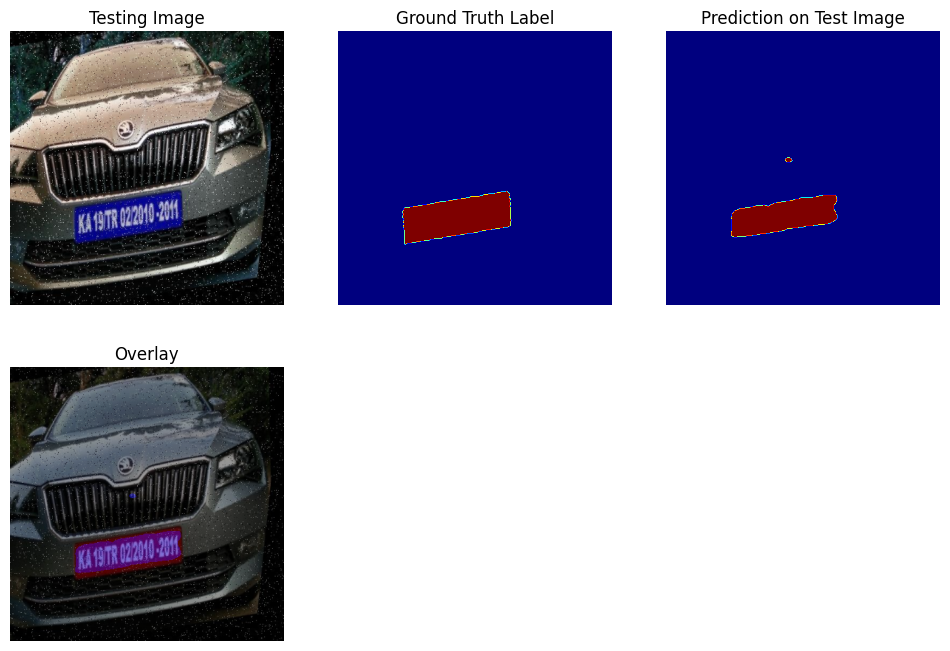

In [30]:


# Create an RGB version of the predicted mask (assuming class labels)
y_pred_rgb = np.zeros((y_pred_argmax.shape[0], y_pred_argmax.shape[1], 3), dtype=np.uint8)
y_pred_rgb[y_pred_argmax == 0] = [0, 0, 0]         # Class 0 (background)
y_pred_rgb[y_pred_argmax == 1] = [255, 0, 0]       # Class 1 (red)

# Blend the original image with the segmented mask
alpha = 0.6  # Adjust the alpha value for blending
overlay = cv2.addWeighted(test_img[0], alpha, y_pred_rgb, 1 - alpha, 0)

# Display the images
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[0], cmap='gray')  # Display the color image
plt.axis('off')

plt.subplot(232)
plt.title('Ground Truth Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet')
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(y_pred_argmax, cmap='jet')
plt.axis('off')

plt.subplot(234)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


#approach for better training

In [ ]:
#Apply a trained model on large image
!pip install patchify
from patchify import patchify, unpatchify

large_image = cv2.imread('/content/licence_plate_segmentation_india-1/train/0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740-jpg_jpeg.rf.38ff3d55fe0ff458f77f962af5c7fd43.jpg', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)

        single_patch = patches[i,j,:,:]
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        # Define the new dimensions (e.g., 416x416)
        new_height = 416
        new_width = 416

        # Resize the image
        single_patch_input = cv2.resize(single_patch_input[0], (new_width, new_height))

        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()

0 0


ValueError: ignored